In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import requests
import asinfo
import clusterbycolumn as cbc

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , stall_duration_total
                  
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           
           and successes = 1
           and failures = 0
           
           and stall_events <> 0
           
           order by dtime DESC
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:24:06,173.194.5.201,31840282


In [9]:
num_probes = len(set(df['probe']))

In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282


In [13]:
df.tail()

,probe,dtime,video_address,stall_duration_total
1868,samsbox10,2014-08-21 15:00:00,2a00:1450:4009:36::e,55735572
1869,samsbox07,2014-08-21 14:00:00,2a00:1450:4009:36::e,55867638
1870,samsbox10,2014-08-21 14:00:00,2a00:1450:4009:36::e,56905588
1871,samsbox07,2014-08-21 13:00:00,2a00:1450:4009:36::e,56793754
1872,samsbox10,2014-08-21 13:00:00,2a00:1450:4009:36::e,56835570


In [14]:
df.count()

probe                   1873
dtime                   1873
video_address           1873
stall_duration_total    1873
dtype: int64

In [15]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [16]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [17]:
dfv4.head()

,probe,dtime,video_address,stall_duration_total
0,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
1,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
2,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
3,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282
4,samsbox88,2017-04-26 23:00:00,173.194.5.201,31840282


In [18]:
dfv6.head()

,probe,dtime,video_address,stall_duration_total
5,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
6,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
7,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
8,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852
9,samsbox83,2017-04-23 14:00:00,2a00:1450:401c:1c::6,33781852


In [19]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [20]:
dfv6.count()

dtime                   1522
video_address           1522
stall_duration_total    1522
name                    1522
dtype: int64

In [21]:
dfv4.count()

dtime                   351
video_address           351
stall_duration_total    351
name                    351
dtype: int64

In [22]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"], how='outer')

In [23]:
df.count()

dtime                     1715
video_address_x            351
stall_duration_total_x     351
name                      1715
video_address_y           1522
stall_duration_total_y    1522
dtype: int64

In [24]:
df.rename(columns={  'video_address_x'             : 'video_ep_4'
                   , 'stall_duration_total_x'      : 'stall_total_4'             
                   , 'video_address_y'             : 'video_ep_6'
                   , 'stall_duration_total_y'      : 'stall_total_6'                                
                  } ,  inplace=True)

In [25]:
df = df.fillna(0)

In [26]:
df.head()

,dtime,video_ep_4,stall_total_4,name,video_ep_6,stall_total_6
0,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
1,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
2,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
3,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0
4,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0


In [27]:
df['46_stall_total']  = df.stall_total_4.map(str) + ',' + df.stall_total_6.map(str)

### Calculate Absolute Difference

In [28]:
def get_difference(v4v6_stall_total):
    
    v4, v6 = v4v6_stall_total.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_stall_total)
    
    difference = (v4 - v6)
    difference = difference / 1000000            
    return float('%0.2f'%difference)

df['st_a'] = df['46_stall_total'].apply(get_difference)

In [29]:
del df['46_stall_total']

In [30]:
df.tail()

,dtime,video_ep_4,stall_total_4,name,video_ep_6,stall_total_6,st_a
1710,2014-08-21 15:00:00,0,0.0,#10,2a00:1450:4009:36::e,55735572.0,-55.74
1711,2014-08-21 14:00:00,0,0.0,#07,2a00:1450:4009:36::e,55867638.0,-55.87
1712,2014-08-21 14:00:00,0,0.0,#10,2a00:1450:4009:36::e,56905588.0,-56.91
1713,2014-08-21 13:00:00,0,0.0,#07,2a00:1450:4009:36::e,56793754.0,-56.79
1714,2014-08-21 13:00:00,0,0.0,#10,2a00:1450:4009:36::e,56835570.0,-56.84


In [31]:
df.head()

,dtime,video_ep_4,stall_total_4,name,video_ep_6,stall_total_6,st_a
0,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0,31.84
1,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0,31.84
2,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0,31.84
3,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0,31.84
4,2017-04-26 23:00:00,173.194.5.201,31840282.0,#88,0,0.0,31.84


In [32]:
df.count()

dtime            1715
video_ep_4       1715
stall_total_4    1715
name             1715
video_ep_6       1715
stall_total_6    1715
st_a             1715
dtype: int64

In [33]:
import Cdf
import Pmf

sample = df['st_a'].values
c      = Cdf.MakeCdfFromList(sample)
cc     = [1 - p for x, p in c.Items()]

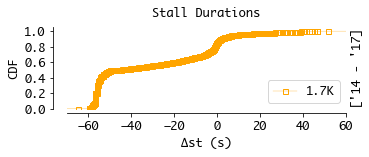

In [34]:
fig = plt.figure(figsize = (5,1.5))
plt.rcParams['font.size'] = 12
ax = plt.gca()
yticks = np.arange(0,1.1,0.2)

plt.plot(c.xs, c.ps, marker='s', linewidth=0.3, markersize=5, fillstyle='none', color = 'orange')

ax = fig.axes[0]
ax.grid(False)
ax.set_yticks(yticks)
ax.set_xlim([-70,60])
ax.set_ylim([0,1.05])
ax.set_xscale('linear')
ax.set_xlabel('∆st (s)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)

plt.legend(["1.7K"], fontsize=12, loc='lower right')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.05))

ax3 = ax.twinx()
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.yaxis.set_ticks_position('none')
ax3.set_ylabel('[\'14 - \'17]')
plt.setp(ax3.get_yticklabels(), visible=False)

plt.title('Stall Durations', fontsize=12, y=1.05)
plt.savefig('yt-stall-durations-absolute-difference.pdf', format='pdf', bbox_inches='tight')

### CDF of absolute difference of stall duration between IPv4 and IPv6 over the entire duration. 14% of the samples experience shorter stall durations over IPv6 with 10% of them being atleast 1s shorter and 4% being atleast 10s shorter. On the contrary, 80% of the samples experience stall durations that are atleast 1s longer over IPv6 with half of them being atleast 50s longer.

In [35]:
with open('yt-stall-durations.csv', 'w') as f: 
    f.write('values; percentile\n')
    for x, y in zip(c.xs, c.ps): f.write('%.2f; %.2f\n'%(x,y))